# Cohort Anomalies

- Identify anomalies and metrics in student access to the Codeup Curriculum

## Goal

Identify:
* most and least popular lessons
* less active students
* suspicious activity
* frequently referenced topics

In [1]:
# local imports
import wrangle as w
import explore as e

#hide warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire

* Data acquired from Codeup MySQL DB
* Data initially acquired on 14 June 2023
* Dataset shape before cleaning:
    * 900,222 rows and 8 columns
* Each row represents a user from a cohort in a Codeup program accessed a specified path to the curriculum
* Each column represents an element of the access, such as date, time, path, etc.

## Prepare

**Prepare Actions**:

* Renamed columns to promote readability and merging
* Removed columns
    - too many null values
    - duplicated information
* Removed nulls
* Checked that column data types were appropriate
* Created custom features to help investigate

In [2]:
# acquire, clean, and prepare the data
df = w.wrangle_logs()

#### A brief look at the data

In [3]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
datetime,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


## Explore

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?

### 1) Which lesson appears to attract the most traffic consistently across cohorts (per program)?

**Web Dev**: javascript-i/introduction/working-with-data-types-operators-and-variables

**Data Science**: classification/overview

In [4]:
# web dev and data science lessons with most traffic
e.question1(df)

Web Dev
lesson: javascript-i/introduction/working-with-data-types-operators-and-variables
count: 6809

Data Science
lesson: classification/overview
count: 1785


### 2) Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

Darden accessed the classification/overview lesson almost 2x as many as the other cohorts combined

In [5]:
# show cohort access counts for a lesson
e.question2(df)

,name,path,path_count
11445,Darden,classification/overview,1109
11721,Easley,classification/overview,445
11067,Curie,classification/overview,136
11914,Florence,classification/overview,60
10618,Bayes,classification/overview,35
7780,Teddy,classification/overview,1


### 3) Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

Yes, there were students who accessed the curriculum less often than there were days in the program they were in. Most were from web dev, in cohorts Oberon, Neptune, and Sequoia. It is possible that some of these students were not able to finish the course and dropped out.

Top Cohorts with # of less active students
Oberon     26
Neptune    21
Sequoia    16
Name: name, dtype: int64


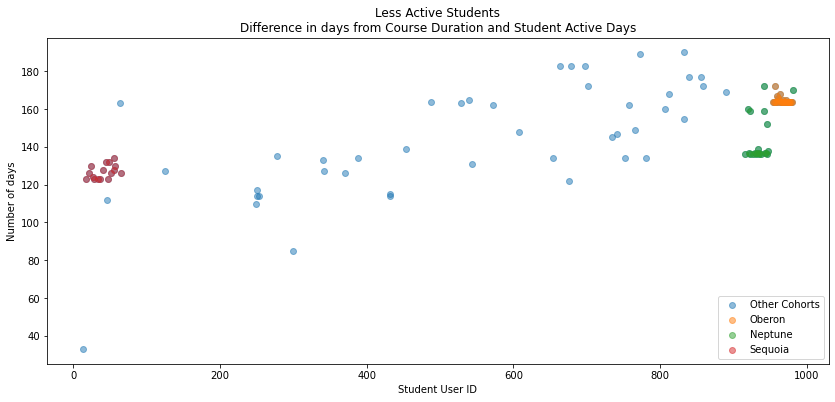

In [6]:
# show less active students with top cohorts highlighted
e.question3(df,True)

### 4) Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In order to check for suspicious server activity we first checked to see which users surpassed a reasonable number of page click-throughs per-day, we then check to see if they are Codeup students or staff.


In [7]:
# Getting anomalies
anomalies = e.anomaly_loop(df, span=30 ,k=3.5)
# e.question4(df)

#### Top 10 users with the highest UB

In [8]:
#top 10 users with the highest ub
print(anomalies.groupby('user_id').sum().sort_values(by='ub', ascending=False).head(10))
df_top_ub = anomalies.groupby('user_id').sum().sort_values(by='ub', ascending=False).head(10)

         pages_one_user    midband          ub          lb      pct_b
user_id                                                              
341                 394  32.825536  381.519192 -315.868120   4.107996
88                  364  26.572468  350.460952 -297.316015  12.290801
248                 256  22.177381  247.247937 -202.893175   4.084065
51                  244  17.050857  232.031640 -197.929927   8.225869
138                 210  17.260447  200.060403 -165.539508   4.126706
146                 204  17.198472  199.278985 -164.882041  11.156121
526                 192  19.601776  187.231096 -148.027544   1.014225
480                 192  18.374059  185.046393 -148.298275   2.032441
344                 189  14.040286  181.375146 -153.294575   6.123186
223                 190  12.469782  178.490178 -153.550615   2.069462


#### Checking the top 10 user IDs we find that they are diligent Codeup students

In [9]:
#loops through df_top_ub user_ids and print out the user_id and the cohort name from the df
for user_id in df_top_ub.index:
    print(user_id)
    print(df[df.user_id == user_id].cohort_id.head(1))


341
datetime
2019-01-22 15:23:24    29.0
Name: cohort_id, dtype: float64
88
datetime
2018-02-05 21:40:45    0.0
Name: cohort_id, dtype: float64
248
datetime
2018-09-05 14:28:23    1.0
Name: cohort_id, dtype: float64
51
datetime
2018-01-27 07:27:52    13.0
Name: cohort_id, dtype: float64
138
datetime
2018-03-09 09:33:19    22.0
Name: cohort_id, dtype: float64
146
datetime
2018-03-19 08:35:51    1.0
Name: cohort_id, dtype: float64
526
datetime
2019-11-04 16:03:38    52.0
Name: cohort_id, dtype: float64
480
datetime
2019-08-20 09:40:44    34.0
Name: cohort_id, dtype: float64
344
datetime
2019-01-22 15:27:46    29.0
Name: cohort_id, dtype: float64
223
datetime
2018-07-23 15:15:27    25.0
Name: cohort_id, dtype: float64


#### No actual anomalies were found

### 5) At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Before the shut off, there were some students accessing the curriculum of both programs. After the shut off, it seemed that of the few students that were trying to access another program's curriculum, most were web dev students.

In [10]:
# data science paths accessed by web dev students
e.question5(df,'wd')

,datetime,path,program_id
341591,2019-12-22 19:41:44,1-fundamentals/1.2-data-science-pipeline,2.0
341596,2019-12-22 19:44:37,1-fundamentals/1.2-data-science-pipeline,2.0
347473,2020-01-13 15:00:39,1-fundamentals/1.1-intro-to-data-science,2.0
347479,2020-01-13 15:02:29,1-fundamentals/1.1-intro-to-data-science,2.0
347510,2020-01-13 15:18:55,1-fundamentals/1.1-intro-to-data-science,2.0
347512,2020-01-13 15:18:58,1-fundamentals/1.1-intro-to-data-science,2.0
347515,2020-01-13 15:19:08,1-fundamentals/1.2-data-science-pipeline,2.0
561978,2020-11-10 10:14:09,fundamentals/intro-to-data-science,2.0
566557,2020-11-17 08:40:22,fundamentals/intro-to-data-science,2.0
581781,2020-12-08 15:28:58,fundamentals/intro-to-data-science,2.0


In [11]:
# java/javascript paths accessed by data science students
e.question5(df,'ds')

,datetime,path,program_id
330331,2019-12-03 11:49:29,javascript-i,3.0
330334,2019-12-03 11:49:33,javascript-ii,3.0
330335,2019-12-03 11:49:35,java-ii,3.0
336295,2019-12-14 16:46:24,javascript-i,3.0
440517,2020-05-19 16:03:32,java-ii/object-oriented-programming,3.0


### 6) What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In order to develop an accurate portrayal of topic headings we first stripped common heading words such as “content”, “appendix”, leading numbers, and then removed “/”, “-”, and other characters. We then aggregated the data frame’s cleaned up paths and program ids and returned the top 10 most visited topics by program.



In [12]:
# function to convert df into df with after graduation data
df_after_grad = e.after_grad(df)


In [13]:
#function to clean up the df_after_grad df
df_after_grad = e.clean_after_grad(df_after_grad)
# e.question6(df)

#### Top 10 post graduation topics for Program 1

path           program_id
javascript-i   1.0           3708
html-css       1.0           3412
mysql          1.0           2371
spring         1.0           2324
java-iii       1.0           1953
jquery         1.0           1742
java-ii        1.0           1572
java-i         1.0           1456
javascript-ii  1.0           1405
laravel        1.0           1188
dtype: int64


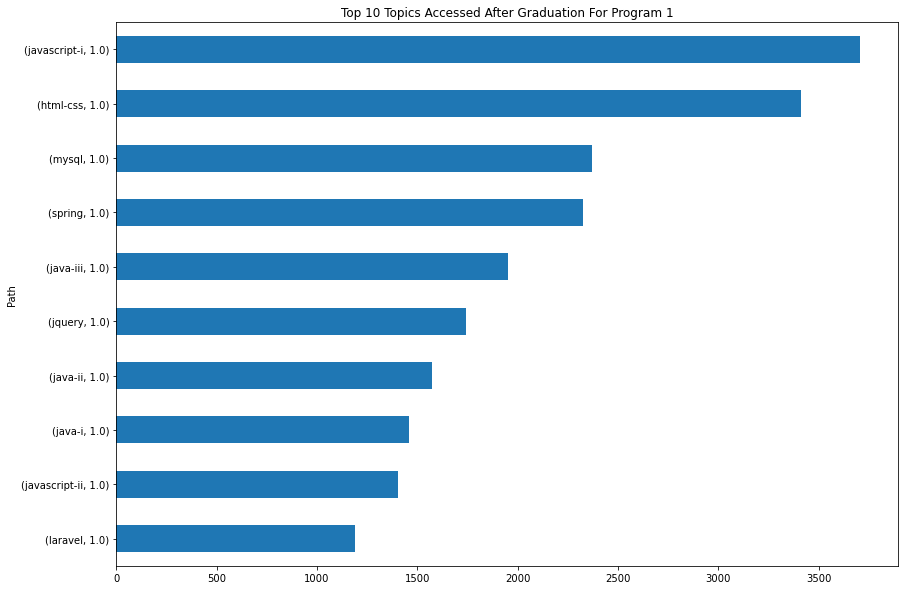

In [14]:
# program 1 top 10 paths accessed after graduation and plots
df_after_grad[df_after_grad['program_id'] == 1.0].value_counts().head(10).sort_values().plot.barh(title='Top 10 Topics Accessed After Graduation For Program 1',xlabel='Path',ylabel='Count',figsize=(14,10))
print(df_after_grad[df_after_grad['program_id'] == 1.0].value_counts().head(10))

#### Top 10 post graduation topics for Program 2

path           program_id
spring         2.0           9640
javascript-i   2.0           9141
html-css       2.0           6860
mysql          2.0           6071
java-ii        2.0           5160
java-i         2.0           5025
java-iii       2.0           4763
jquery         2.0           4118
javascript-ii  2.0           4090
php_i          2.0            664
dtype: int64


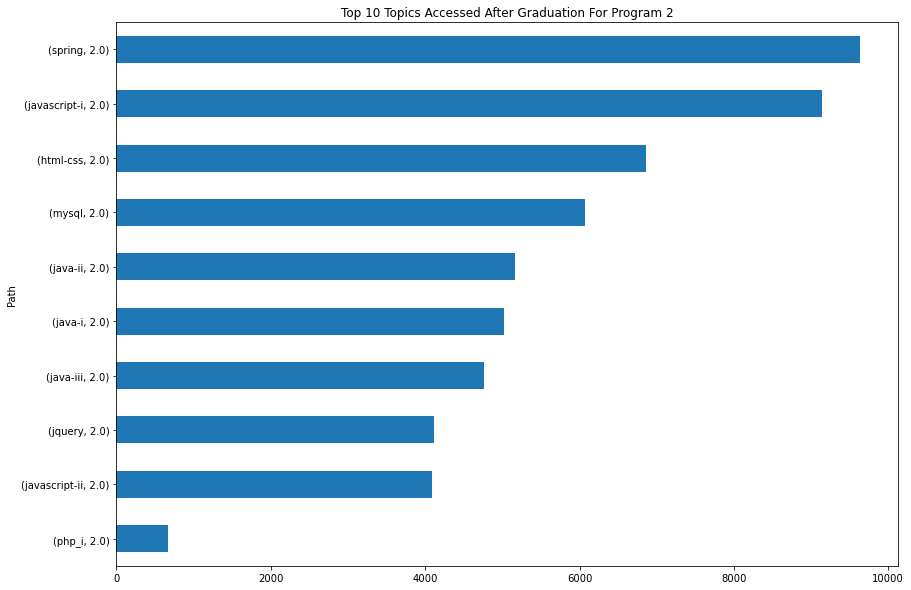

In [15]:
#list and plots top 10 topics for program_id 2.0
df_after_grad[df_after_grad['program_id'] == 2.0].value_counts().head(10).sort_values().plot.barh(title='Top 10 Topics Accessed After Graduation For Program 2',xlabel='Path',ylabel='Count',figsize=(14,10))
print(df_after_grad[df_after_grad['program_id'] == 2.0].value_counts().head(10))

#### Top 10 post graduation topics for Group 3

path               program_id
sql                3.0           1554
fundamentals       3.0           1520
classification     3.0           1316
python             3.0            845
regression         3.0            710
anomaly-detection  3.0            628
stats              3.0            527
timeseries         3.0            497
nlp                3.0            487
clustering         3.0            340
dtype: int64


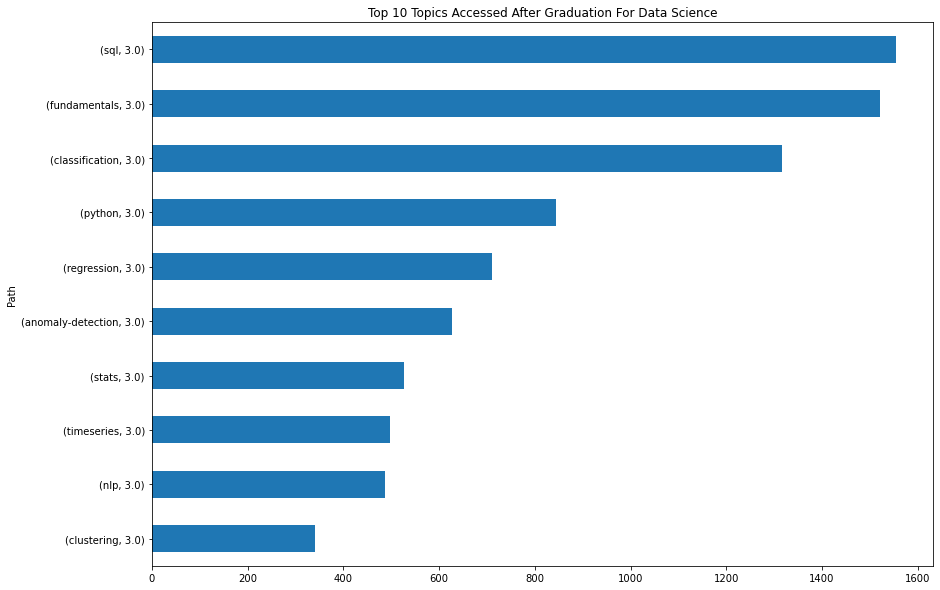

In [16]:
#lists and plots top 10 topics for program_id 3.0
df_after_grad[df_after_grad['program_id'] == 3.0].value_counts().head(10).sort_values().plot.barh(title='Top 10 Topics Accessed After Graduation For Data Science',xlabel='Path',ylabel='Count',figsize=(14,10))
print(df_after_grad[df_after_grad['program_id'] == 3.0].value_counts().head(10))

### 7) Which lessons are least accessed?

We used the post graduation dataframe created above to analyze the lessons accessed the fewest times. To do this, we removed lessons only accessed once in order to avoid counting possible miss-clicks. We then sorted by group.  

#### Programs 1 and 2 least accessed lessons after graduation:

In [17]:
#program_id 1 and 2 bottom 30 paths accessed with more than 1 count 
df_after_grad[df_after_grad['program_id'] != 3.0].value_counts().where(lambda x: x > 1).dropna().tail(30)

path                              program_id
primitive-types.html              1.0           2.0
quiz                              2.0           2.0
register.html                     1.0           2.0
_intro                            2.0           2.0
anomaly-detection                 1.0           2.0
._Intro_Clustering                1.0           2.0
Intro_to_Regression_Module        1.0           2.0
.._ConnectingToSpark              2.0           2.0
.._Correlation                    2.0           2.0
.._DecisionTree                   2.0           2.0
.._KNN                            2.0           2.0
._Anomaly_Detection               2.0           2.0
.._Descriptive_Stats              1.0           2.0
._DistributedML.md                2.0           2.0
..-where                          2.0           2.0
.._introduction_to_seaborn        1.0           2.0
..-subqueries                     2.0           2.0
..-relationships-overview         2.0           2.0
..-order-by        

Program 1 and 2 (web dev) accessed data science lessons but at lesser rate versus web dev lessons.

#### Program 3's least accessed lessons after graduation:

In [18]:
#program_id 3.0 bottom 10 paths accessed with more than 1 count but less than 5
df_after_grad[df_after_grad['program_id'] == 3.0].value_counts().where(lambda x: x > 1).dropna().tail(30)

path                                            program_id
sql                                             3.0           1554.0
fundamentals                                    3.0           1520.0
classification                                  3.0           1316.0
python                                          3.0            845.0
regression                                      3.0            710.0
anomaly-detection                               3.0            628.0
stats                                           3.0            527.0
timeseries                                      3.0            497.0
nlp                                             3.0            487.0
clustering                                      3.0            340.0
distributed-ml                                  3.0            231.0
storytelling                                    3.0            190.0
advanced-topics                                 3.0            185.0
capstones                                   

Program 3 (Data Science) accessed data science lessons (and for the most part only data science) after graduation at higher rate even looking at the bottom 30.

## Exploration Summary and Conclusion

- All time most referenced lesson per Program:
    - **Web Dev**: Javascript-I – Intro – Working with Data Types, Operators, and Variables
    - **Data Science**: Classification – Overview (referenced mostly by Darden Cohort)
- Top 3 referenced topics per Program after graduation:
    - **Web Dev**: Spring, Javascript-I, and HTML-CSS
    - **Data Science**: SQL, Fundamentals, and Classification
- There were some students who accessed the curriculum less often than there were days in the program they were in. Most were from web dev, in cohorts Oberon, Neptune, and Sequoia. It is possible that some of these students were not able to finish the course and dropped out.
- Before the cross-curriculum access was shut off, there were some students accessing the curriculum of both programs. After the shut off, it seemed that of the few students that were trying to access another program's curriculum, most were web dev students.
- After graduation the web dev alumni’s least accessed lessons were those belonging to the data science curriculum, such as, Descriptive Stats, Intro to Seaborn, and Module: Classification. The data science alumni, on the other hand,  primarily accessed lessons from their curriculum, such as, Classical Programming vs Machine Learning, Selecting a Hypothesis Test, and Advanced Topics.
- No actual security anomalies were detected. The outliers found in our analysis turned out to be diligent students or hard working staff.  





### Recommendations and Next Steps
* We should send out an alumni survey to ascertain if the frequently searched for topics on the Codeup site were thoroughly covered during their course and take appropriate action. Additionally, any overlap in currently covered topics and searched for topics should be specifically emphasized as soon as possible. 